In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
import itertools
from IPython.display import display

%matplotlib inline


In [2]:
x_train = pd.read_csv('/home/rashmi/BE Project/pre-processed/s2e/audio_train.csv')
x_test = pd.read_csv('/home/rashmi/BE Project/pre-processed/s2e/audio_test.csv')

print(x_train.shape)
y_train = x_train['label']
y_test = x_test['label']

(1704, 10)


In [3]:
print(x_train.shape, x_test.shape)
cl_weight = dict(pd.Series(x_train['label']).value_counts(normalize=True))
print(dict(pd.Series(x_train['label']).value_counts()))

del x_train['label']
del x_test['label']
del x_train['wav_file']
del x_test['wav_file']

(1704, 10) (426, 10)
{2: 508, 1: 357, 5: 297, 3: 242, 4: 165, 0: 135}


In [4]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

Test Set Accuracy =  0.540
Test Set F-score =  0.565
Test Set Precision =  0.593
Test Set Recall =  0.576
Confusion matrix, without normalization
[[10 17  6  0  0  2]
 [ 4 30 35  0  3 13]
 [ 3 34 69  1  3  8]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 33  0]
 [ 0 19 44  1  3 20]]


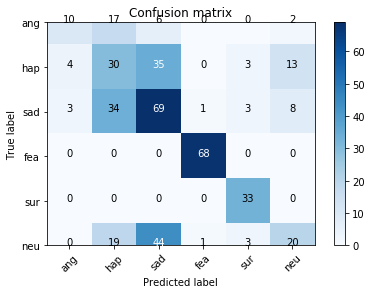

In [5]:
rf_classifier = RandomForestClassifier(n_estimators=1200, min_samples_split=25)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)
# print(pred_probs)
#Results
display_results(y_test, pred_probs)

with open('/home/rashmi/BE Project/pre-processed/pred_probas/rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.559
Test Set F-score =  0.584
Test Set Precision =  0.608
Test Set Recall =  0.583
Confusion matrix, without normalization
[[ 8 15  9  1  0  2]
 [ 5 33 34  0  0 13]
 [ 6 28 74  0  0 10]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 33  0]
 [ 1 15 48  1  0 22]]


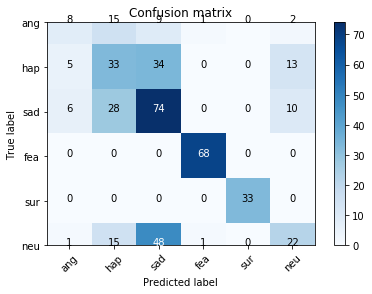

In [6]:
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                   n_estimators=1200, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('/home/rashmi/BE Project/pre-processed/pred_probas/xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.559
Test Set F-score =  0.584
Test Set Precision =  0.608
Test Set Recall =  0.583
Confusion matrix, without normalization
[[ 8 15  9  1  0  2]
 [ 5 33 34  0  0 13]
 [ 6 28 74  0  0 10]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 33  0]
 [ 1 15 48  1  0 22]]


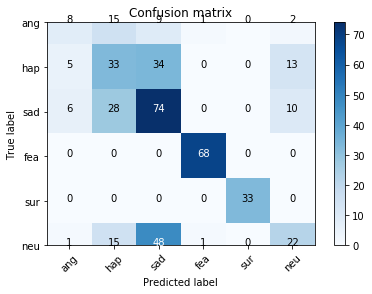

In [8]:
svc_classifier = LinearSVC()

svc_classifier.fit(x_train, y_train)

# Predict
pred = svc_classifier.predict(x_test)

# Results
display_results(y_test, pred_probs)

with open('/home/rashmi/BE Project/pre-processed/pred_probas/svc_classifier_model.pkl', 'wb') as f:
    pickle.dump(pred, f)

Test Set Accuracy =  0.531
Test Set F-score =  0.558
Test Set Precision =  0.550
Test Set Recall =  0.570
Confusion matrix, without normalization
[[ 8 10 11  0  0  6]
 [ 8 31 31  0  3 12]
 [11 29 53  0  1 24]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 33  0]
 [ 4 16 30  2  2 33]]


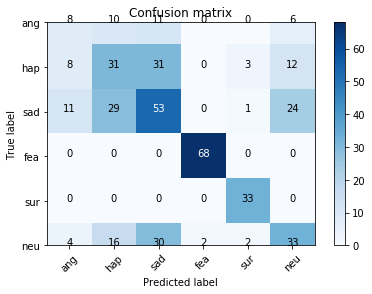

In [9]:
dt_classifier = tree.DecisionTreeClassifier()

dt_classifier.fit(x_train, y_train)

# Predict
pred_probs = dt_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('/home/rashmi/BE Project/pre-processed/pred_probas/dt_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.484
Test Set F-score =  0.522
Test Set Precision =  0.515
Test Set Recall =  0.544
Confusion matrix, without normalization
[[12 11 11  1  0  0]
 [12 26 32  0  3 12]
 [ 4 44 51  3  0 16]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 33  0]
 [ 6 21 37  3  4 16]]


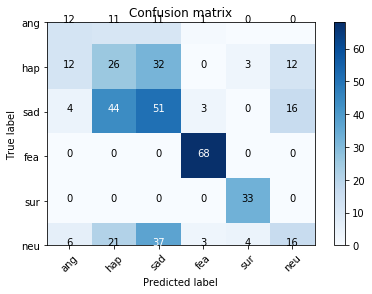

In [20]:
knn_classifier = KNeighborsClassifier(n_neighbors=4)

knn_classifier.fit(x_train, y_train)

# Predict
pred_probs = knn_classifier.predict_proba(x_test)
# Results
display_results(y_test, pred_probs)

with open('/home/rashmi/BE Project/pre-processed/pred_probas/knn_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.547
Test Set F-score =  0.578
Test Set Precision =  0.600
Test Set Recall =  0.582
Confusion matrix, without normalization
[[10 12  9  2  0  2]
 [ 5 34 36  0  2  8]
 [ 5 32 67  1  0 13]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 33  0]
 [ 1 16 47  1  1 21]]


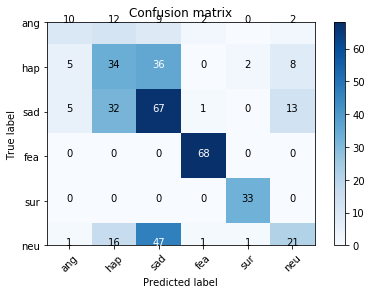

In [16]:
# Load predicted probabilities
# Load predicted probabilities
with open('/home/rashmi/BE Project/pre-processed/pred_probas/rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)

with open('/home/rashmi/BE Project/pre-processed/pred_probas/xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('/home/rashmi/BE Project/pre-processed/pred_probas/svc_classifier_model.pkl', 'rb') as f:
    svc_preds = pickle.load(f)
    
with open('/home/rashmi/BE Project/pre-processed/pred_probas/dt_classifier.pkl', 'rb') as f:
    dt_pred_probs = pickle.load(f)
    
with open('/home/rashmi/BE Project/pre-processed/pred_probas/knn_classifier.pkl', 'rb') as f:
    knn_pred_probs = pickle.load(f)
    

# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       knn_pred_probs +
                       rf_pred_probs)/3.0
# print(ensemble_pred_probs)
# Show metrics
display_results(y_test, ensemble_pred_probs)

Test Set Accuracy =  0.540
Test Set F-score =  0.570
Test Set Precision =  0.566
Test Set Recall =  0.579
Confusion matrix, without normalization
[[ 9  9 11  0  0  6]
 [ 6 31 34  0  3 11]
 [10 28 56  0  1 23]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 33  0]
 [ 3 16 32  1  2 33]]


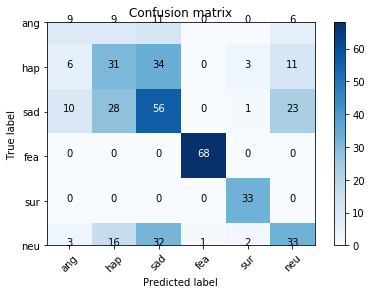

In [17]:
# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       dt_pred_probs +
                       rf_pred_probs)/3.0
# print(ensemble_pred_probs)
# Show metrics
display_results(y_test, ensemble_pred_probs)

Test Set Accuracy =  0.531
Test Set F-score =  0.564
Test Set Precision =  0.561
Test Set Recall =  0.572
Confusion matrix, without normalization
[[ 9  9 11  0  0  6]
 [ 4 30 34  0  3 14]
 [10 29 56  0  1 22]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 33  0]
 [ 4 14 36  2  1 30]]


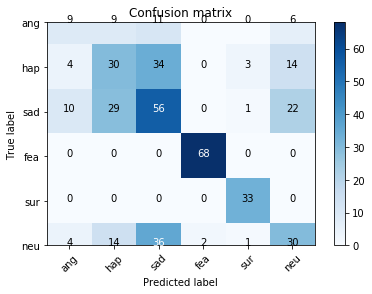

In [18]:
# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       dt_pred_probs +
                       knn_pred_probs)/3.0
# print(ensemble_pred_probs)
# Show metrics
display_results(y_test, ensemble_pred_probs)

Test Set Accuracy =  0.526
Test Set F-score =  0.553
Test Set Precision =  0.546
Test Set Recall =  0.565
Confusion matrix, without normalization
[[ 8 10 11  0  0  6]
 [ 6 29 34  0  4 12]
 [10 29 55  0  1 23]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 33  0]
 [ 4 14 34  2  2 31]]


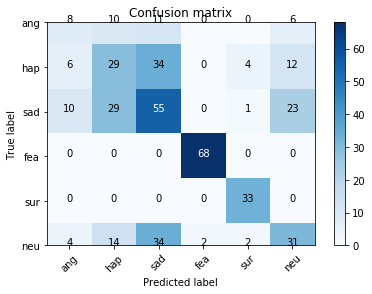

In [19]:
# Average of the predicted probabilites
ensemble_pred_probs = (knn_pred_probs +
                       dt_pred_probs +
                       rf_pred_probs)/3.0
# print(ensemble_pred_probs)
# Show metrics
display_results(y_test, ensemble_pred_probs)